In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
import pingouin as pg
#import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [28]:
# Load file (from same directory as the notebook)
DATA1 = pd.read_excel(os.path.expanduser("MnemonicALL.xlsx"))
DATA1.head()

,Response ID,CONDITION,PRE,PRE1,PRE2,PRE3,PRE4,PRE5,PRE6,PRE7,...,RBI3,RBI4,RBD1,RBD2,RBD3,RBD4,RBD5,RBD6,RBD7,RBD8
0,R_C1gtq3vaQMh4LDP,1,NaN,1.0,1.5,5.0,1.0,1.0,4.0,4.0,...,21.428571,28.571429,0.000000,7.142857,-14.285714,14.285714,28.571429,28.571429,-28.571429,-14.285714
1,R_OIKKCPFEqENbBLz,1,NaN,5.0,5.0,5.0,6.0,4.0,6.0,6.0,...,0.000000,-21.428571,-14.285714,0.000000,35.714286,-7.142857,7.142857,0.000000,7.142857,-35.714286
2,R_5hhFvCRPUdA1Cvv,1,NaN,6.0,4.5,4.5,5.0,2.5,5.5,3.5,...,7.142857,42.857143,7.142857,0.000000,35.714286,7.142857,-7.142857,7.142857,7.142857,-14.285714
3,R_33DBIOPXhDsQ4pF,1,NaN,6.0,3.0,4.5,3.0,2.0,3.0,5.0,...,-14.285714,7.142857,-21.428571,0.000000,14.285714,0.000000,42.857143,28.571429,14.285714,7.142857
4,R_3KAVC58luAIHxGH,1,NaN,5.0,1.0,2.0,4.5,1.0,1.0,5.0,...,21.428571,57.142857,7.142857,21.428571,21.428571,7.142857,71.428571,-28.571429,57.142857,7.142857


In [29]:
# Extract columns with DATA1.target or DATA1["target"] or DATA1.loc[:,"target"]
participant = DATA1.loc[:,"Response ID"]

# Extract DATA1 with DATA1.loc[:,"DATA1start":"DATA1end"]
Pre = DATA1.loc[:, "PreI1":"PreI4"]
RBU = DATA1.loc[:, "RBI1":"RBI4"]

sz = Pre.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["Pre", "RBU", "itemnum", "partnum"]
DATA1_packed = np.broadcast_arrays(Pre, RBU, itemnum, partnum)
DATA1_unpacked = [np.reshape(a, -1) for a in DATA1_packed]

DATA1 = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, DATA1_unpacked)})

DATA1.head()

,Pre,RBU,itemnum,partnum
0,71.428571,0.000000,0,0
1,14.285714,0.000000,1,0
2,50.000000,21.428571,2,0
3,42.857143,28.571429,3,0
4,71.428571,0.000000,0,1


<IPython.core.display.Javascript object>


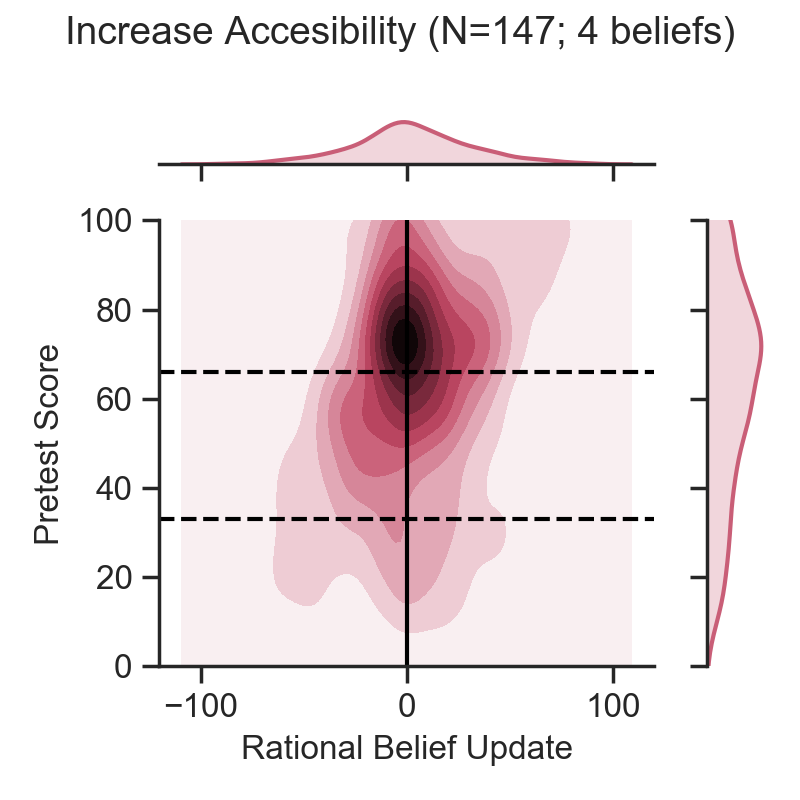

In [30]:
axs = sns.jointplot(
    data=DATA1,
    x="RBU", y="Pre", height=4, ratio=5, color="#C95E77",
    kind="kde", ylim=[0,100])

axs.fig.suptitle("Increase Accesibility (N=147; 4 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')
axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")
plt.savefig('MemoryINC.tif', dpi=300, format="tiff")

In [31]:
# Load file (from same directory as the notebook)
DATA2 = pd.read_excel(os.path.expanduser("MnemonicALL.xlsx"))
DATA2.head()

,Response ID,CONDITION,PRE,PRE1,PRE2,PRE3,PRE4,PRE5,PRE6,PRE7,...,RBI3,RBI4,RBD1,RBD2,RBD3,RBD4,RBD5,RBD6,RBD7,RBD8
0,R_C1gtq3vaQMh4LDP,1,NaN,1.0,1.5,5.0,1.0,1.0,4.0,4.0,...,21.428571,28.571429,0.000000,7.142857,-14.285714,14.285714,28.571429,28.571429,-28.571429,-14.285714
1,R_OIKKCPFEqENbBLz,1,NaN,5.0,5.0,5.0,6.0,4.0,6.0,6.0,...,0.000000,-21.428571,-14.285714,0.000000,35.714286,-7.142857,7.142857,0.000000,7.142857,-35.714286
2,R_5hhFvCRPUdA1Cvv,1,NaN,6.0,4.5,4.5,5.0,2.5,5.5,3.5,...,7.142857,42.857143,7.142857,0.000000,35.714286,7.142857,-7.142857,7.142857,7.142857,-14.285714
3,R_33DBIOPXhDsQ4pF,1,NaN,6.0,3.0,4.5,3.0,2.0,3.0,5.0,...,-14.285714,7.142857,-21.428571,0.000000,14.285714,0.000000,42.857143,28.571429,14.285714,7.142857
4,R_3KAVC58luAIHxGH,1,NaN,5.0,1.0,2.0,4.5,1.0,1.0,5.0,...,21.428571,57.142857,7.142857,21.428571,21.428571,7.142857,71.428571,-28.571429,57.142857,7.142857


In [32]:
# Extract columns with DATA2.target or DATA2["target"] or DATA2.loc[:,"target"]
participant = DATA2.loc[:,"Response ID"]

# Extract DATA2 with DATA2.loc[:,"DATA2start":"DATA2end"]
Pre = DATA2.loc[:, "PreD1":"PreD8"]
RBU = DATA2.loc[:, "RBD1":"RBD8"]

sz = Pre.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["Pre", "RBU", "itemnum", "partnum"]
DATA2_packed = np.broadcast_arrays(Pre, RBU, itemnum, partnum)
DATA2_unpacked = [np.reshape(a, -1) for a in DATA2_packed]

DATA2 = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, DATA2_unpacked)})

DATA2.head()

,Pre,RBU,itemnum,partnum
0,14.285714,0.000000,0,0
1,21.428571,7.142857,1,0
2,14.285714,-14.285714,2,0
3,57.142857,14.285714,3,0
4,57.142857,28.571429,4,0


<IPython.core.display.Javascript object>


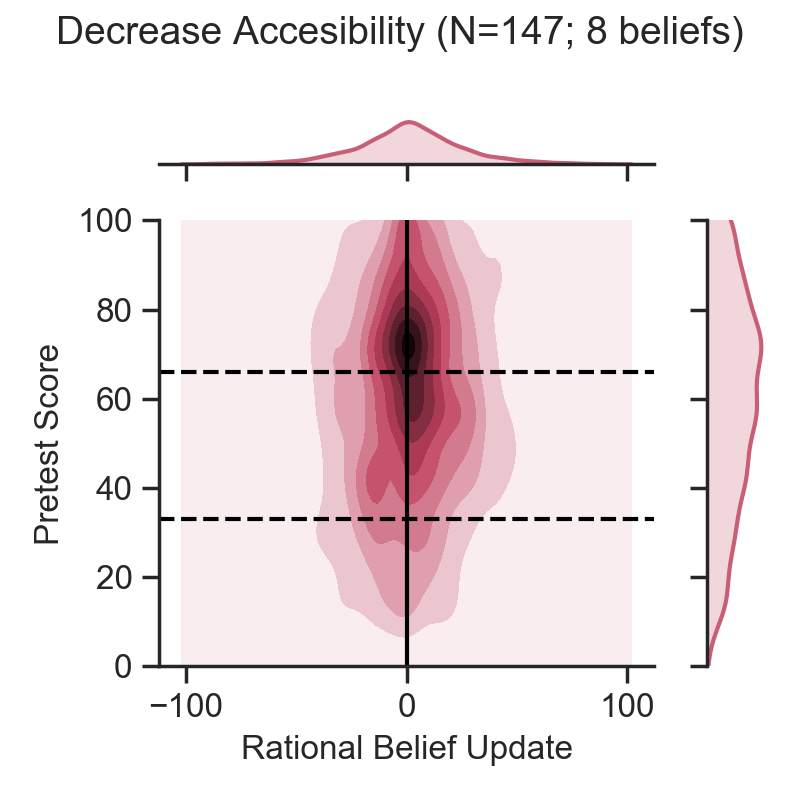

In [33]:
axs = sns.jointplot(
    data=DATA2,
    x="RBU", y="Pre", height=4, ratio=5, color="#C95E77",
    kind="kde", ylim=[0,100])

axs.fig.suptitle("Decrease Accesibility (N=147; 8 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')
axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")
plt.savefig('MemoryDEC.tif', dpi=300, format="tiff")

In [34]:
# Load file (from same directory as the notebook)
DATA3 = pd.read_excel(os.path.expanduser("EmotionALL.xlsx"))
DATA3.head()

,Response ID,condition,1,2,3,4,5,6,7,8,...,Pre3,Pre4,Pre5,Pre6,RB1,RB2,RB3,RB4,RB5,RB6
0,R_1jiHgByQacfxRej,1,79,20,82,100,73,50,51,40,...,82,10,29,35,7,7,-16,5,-45,-5
1,R_2AFhJVuKsmyFoFv,1,60,28,31,93,61,82,6,90,...,31,28,71,71,33,33,51,66,11,-56
2,R_1etletl1lPtNOyY,1,43,46,52,73,30,41,30,35,...,52,42,36,42,4,-15,-4,2,-23,-2
3,R_1OJMsgjD5E7VxhF,1,5,19,80,100,77,89,99,97,...,80,86,5,5,-5,-42,-12,4,4,-3
4,R_2pY8m4uvoZu8rSi,1,82,30,19,71,72,72,31,81,...,19,30,20,30,-14,6,24,-2,11,-1


In [35]:
# Extract columns with DATA3.target or DATA3["target"] or DATA3.loc[:,"target"]
participant = DATA3.loc[:,"Response ID"]

# Extract DATA3 with DATA3.loc[:,"DATA3start":"DATA3end"]
Pre = DATA3.loc[:, "Pre1":"Pre6"]
RBU = DATA3.loc[:, "RB1":"RB6"]

sz = Pre.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["Pre", "RBU", "itemnum", "partnum"]
DATA3_packed = np.broadcast_arrays(Pre, RBU, itemnum, partnum)
DATA3_unpacked = [np.reshape(a, -1) for a in DATA3_packed]

DATA3 = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, DATA3_unpacked)})

DATA3.head()

,Pre,RBU,itemnum,partnum
0,79,7,0,0
1,20,7,1,0
2,82,-16,2,0
3,10,5,3,0
4,29,-45,4,0


<IPython.core.display.Javascript object>


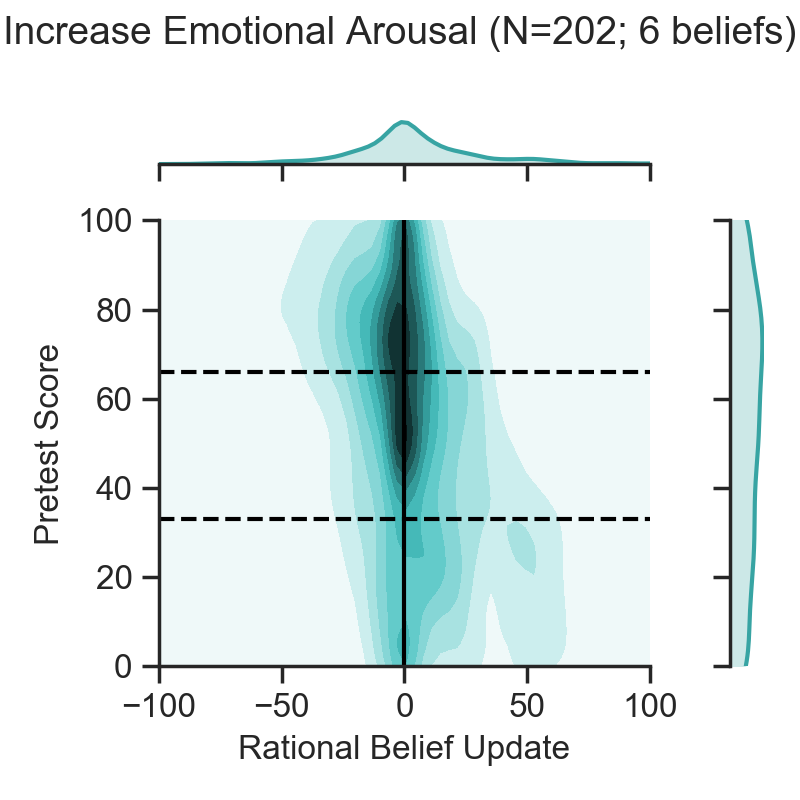

In [36]:
axs = sns.jointplot(
    data=DATA3,
    x="RBU", y="Pre", height=4, ratio=5, color="#37A4A3",
    kind="kde", xlim=[-100,100], ylim=[0,100])

axs.fig.suptitle("Increase Emotional Arousal (N=202; 6 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')
axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")
plt.savefig('Emotion.tif', dpi=300, format="tiff")

In [37]:
# Load file (from same directory as the notebook)
DATA4 = pd.read_excel(os.path.expanduser("PredictionALL.xlsx"), index_col=0)
DATA4.head()

,cond,party,CHANGE,1N,2N,3N,4N,5N,6N,7N,...,3R.2,4R.2,5R.2,6R.2,7R.2,8R.2,9R.2,10R.2,11R.2,12R.2
Response ID,,,,,,,,,,,,,,,,,,,,,
Over_Under,NaN,NaN,NaN,1,1,1,0,0,0,1,...,1,0,0,0,1,1,1,0,0,0
Support_Against,NaN,NaN,NaN,1,1,1,1,1,1,0,...,1,1,1,1,0,0,0,0,0,0
Dem_Rep_Ind,NaN,NaN,NaN,3,3,3,3,3,3,3,...,2,2,2,2,2,2,2,2,2,2
R_Q05BXFYLTih4gdr,2.0,1.0,NaN,3,9,99,-3,17,0,-1,...,82,74,6,11,7,20,73,69,38,0
R_3CMkUHMX39AaEEh,2.0,1.0,NaN,72,40,70,-44,51,91,-13,...,17,3,25,72,52,17,1,32,20,36


In [38]:
nitemlabel = 3
overunder = DATA4.loc["Over_Under", "1N":"12R"]
supportagainst = DATA4.loc["Support_Against", "1N":"12R"]
itemideology = DATA4.loc["Dem_Rep_Ind", "1N":"12R"]
itemnum = np.arange(itemideology.size)
maxPE = np.array([10,9,7,6,8,11,8,6,11,10,9,7,9,7,10,6,8,11,11,8,6,9,10,7,7,9,10,8,11,6,11,8,6,7,10,9])
DATA4trim = DATA4.iloc[nitemlabel:, :]
cond = DATA4trim.loc[:, "cond"]
partideology = DATA4trim.loc[:, "party"]
partnum = np.arange(partideology.size)
deltaB = DATA4trim.loc[:, "1N":"12R"]
signedPE = DATA4trim.loc[:, "1N.1":"12R.1"]
PE = signedPE.abs().astype(int)
Bpre = DATA4trim.loc[:, "1N.2":"12R.2"]
sz = deltaB.shape
print(sz)

(1777, 36)


In [39]:
names = ["deltaB", "signedPE", "PE", "Bpre", "overunder", "supportagainst", "itemideology", "maxPE", "itemnum", \
        "cond", "partideology", "partnum"]
data_packed = np.broadcast_arrays(deltaB, signedPE, PE, Bpre, overunder, supportagainst, itemideology, maxPE, itemnum)
cols = [np.tile(a, (sz[1],1)).T for a in [cond, partideology, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA4 = pd.DataFrame(data=data_unpacked, columns=names)

In [40]:
# We add a small positive number to prediction errors such that sign(0) = 1
RUD = np.sign(DATA4["supportagainst"] - 0.5) * np.sign(DATA4["overunder"] - 0.5) * np.sign(DATA4["signedPE"] + 0.01)
RUD_control = np.sign(DATA4["supportagainst"] - 0.5)
RUD[DATA4["cond"]==2] = RUD_control[DATA4["cond"]==2]
# Rational belief update
RdeltaB = DATA4["deltaB"]*RUD
if "RdeltaB" in DATA4:
    DATA4["RdeltaB"] = RdeltaB
else:
    DATA4.insert(0, "RdeltaB", RdeltaB)
# Rational update interval
RpreI = np.abs((RUD+1)*50 - DATA4["Bpre"])
if "RpreI" in DATA4:
    DATA4["RpreI"] = RpreI
else:
    DATA4.insert(5, "RpreI", RpreI)
if "RpreI" in DATA4:
    DATA4["RpreI"] = RpreI
else:
    DATA4.insert(5, "RpreI", RpreI)

DATA4.head()

,RdeltaB,deltaB,signedPE,PE,Bpre,RpreI,overunder,supportagainst,itemideology,maxPE,itemnum,cond,partideology,partnum
0,3.0,3.0,0.0,0.0,66.0,34.0,1.0,1.0,3.0,10.0,0.0,2.0,1.0,0.0
1,9.0,9.0,0.0,0.0,69.0,31.0,1.0,1.0,3.0,9.0,1.0,2.0,1.0,0.0
2,99.0,99.0,0.0,0.0,1.0,99.0,1.0,1.0,3.0,7.0,2.0,2.0,1.0,0.0
3,-3.0,-3.0,0.0,0.0,74.0,26.0,0.0,1.0,3.0,6.0,3.0,2.0,1.0,0.0
4,17.0,17.0,0.0,0.0,66.0,34.0,0.0,1.0,3.0,8.0,4.0,2.0,1.0,0.0


In [41]:
DATA4_exp = DATA4.loc[DATA4["cond"]==1]
DATA4_control = DATA4.loc[DATA4["cond"]==2]

nexp = DATA4_exp.loc[:, "partnum"].unique().size
ncontrol = DATA4_control.loc[:, "partnum"].unique().size
pairidx = np.random.randint(0, ncontrol, (nexp,))
pairDATA4 = [part for _, part in DATA4_control.groupby("partnum")]

pairRdeltaB = pd.concat([pairDATA4[i].loc[:, "RdeltaB"] for i in pairidx])
DATA4_exp["RdeltaB"] = np.array(DATA4_exp.loc[:,"RdeltaB"]) - np.array(pairRdeltaB)

<IPython.core.display.Javascript object>


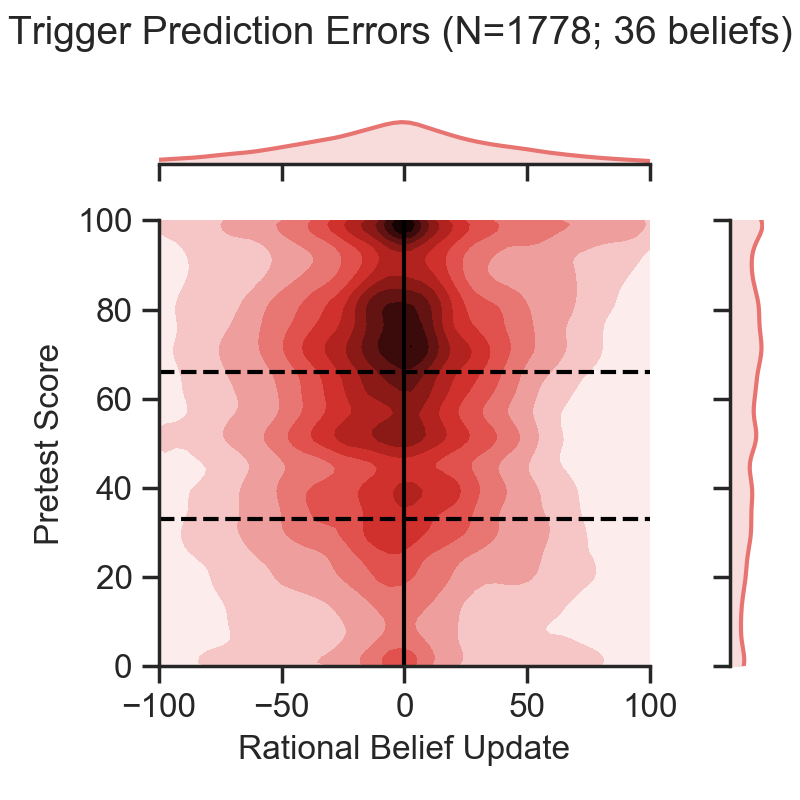

In [86]:
axs = sns.jointplot(
    data=DATA4_exp,
    x="RdeltaB", y="Bpre", height=4, ratio=5, color="#E77471",
    kind="kde", xlim=[-100,100], ylim=[0,100])

axs.fig.suptitle("Trigger Prediction Errors (N=1778; 36 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')
axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")
plt.savefig('Prediction.tif', dpi=300, format="tiff")

In [43]:
# Load file (from same directory as the notebook)
DATA5 = pd.read_excel(os.path.expanduser("NormsALL.xlsx"), index_col=0)
DATA5.head()

,GENDER,AGE,PARTY,TWITTER,TRUST,RATIONALUPDATE,RU1,RU2,RU3,RU4,...,Pre23,Pre24,Pre25,Pre26,Pre27,Pre28,Pre29,Pre30,Pre31,Pre32
Response ID,,,,,,,,,,,,,,,,,,,,,
R_0cj5dsJg2wfpiuJ,1,18,1,0,95,NaN,4.0,26,0,-5,...,66,59,21,63,66,61,60,63,89,35
R_0rkhLjwWPHHjnTX,0,19,2,1,76,NaN,-5.0,16,3,-1,...,60,71,43,65,44,37,62,63,57,43
R_10BMNpjhInMfUeO,1,18,1,1,86,NaN,-5.0,-2,5,5,...,78,45,39,80,43,62,61,55,61,45
R_120iGR6WlLnbZnI,0,22,1,0,95,NaN,23.0,-10,-40,22,...,9,72,18,24,72,81,30,59,69,19
R_12qW8cDY0bNlId2,0,19,3,0,76,NaN,18.0,-12,1,16,...,30,75,20,68,72,36,63,52,88,63


In [44]:
def get_condnum(X):
    return np.mod(np.where(X)[-1], 4)
def sample(data, locs):
    idx = locs + 4*np.arange(locs.size)
    return data[idx]

In [45]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = DATA5.loc[:, "AGE"]
party = DATA5.loc[:, "PARTY"]
twitter = DATA5.loc[:, "TWITTER"]
trust = DATA5.loc[:,"TRUST"]
partnum = np.arange(trust.size)

In [46]:
# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = DATA5.loc[:, "RU1":"RU32"]
Pre = DATA5.loc[:, "Pre1":"Pre32"]
convincing = DATA5.loc[:, "APT1":"SUT32"]
cond_place = np.logical_not(np.isnan(convincing))

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(200, 32)


In [47]:
#Compress condition-wise data into a single data matrix and labels
cond = np.array([get_condnum(cond_place.iloc[i,:]) for i in range(sz[0])])
# ^ Labels
convincing = np.array([sample(convincing.iloc[i], cond[i]) for i in range(sz[0])])

In [48]:
# Data and row-wise labels first
names = ["RdeltaB","Pre", "convincing", "cond", "itemnum", \
         "age", "party", "twitter", "trust", "partnum"]
data_packed = np.broadcast_arrays(RdeltaB, Pre, convincing, cond, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, party, twitter, trust, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA5 = pd.DataFrame(data=data_unpacked, columns=names)

ticklbl = ["Anec, Norm","Anec, Non-Norm","Sci, Norm","Sci, Non-Norm"]

DATA5.head()

,RdeltaB,Pre,convincing,cond,itemnum,age,party,twitter,trust,partnum
0,4.0,83.0,66.0,3.0,0.0,18.0,1.0,0.0,95.0,0.0
1,26.0,64.0,66.0,0.0,1.0,18.0,1.0,0.0,95.0,0.0
2,0.0,20.0,56.0,0.0,2.0,18.0,1.0,0.0,95.0,0.0
3,-5.0,30.0,56.0,3.0,3.0,18.0,1.0,0.0,95.0,0.0
4,4.0,86.0,61.0,3.0,4.0,18.0,1.0,0.0,95.0,0.0


In [49]:
DATA5_high = DATA5.loc[DATA5["cond"] % 2 == 0]
DATA5_low = DATA5.loc[DATA5["cond"] % 2 != 0]
# Each participant has approx half of items in the high condition, approx half in low condition
# Bootstrap iter: For each participant's high and low items' RdeltaB, 
#                 resample one of the low items' RdeltaB (with replacement) per high item,
#                 subtract the resampled low items from the high items. 
pairRdeltaB = np.hstack([np.random.choice(lo["RdeltaB"], size=(hi.shape[0],)) \
                         for (_, hi), (_, lo) in \
                         zip(DATA5_high.groupby("partnum"), DATA5_low.groupby("partnum"))])
DATA5_high["RdeltaB"] = np.array(DATA5_high["RdeltaB"]) - pairRdeltaB

<IPython.core.display.Javascript object>


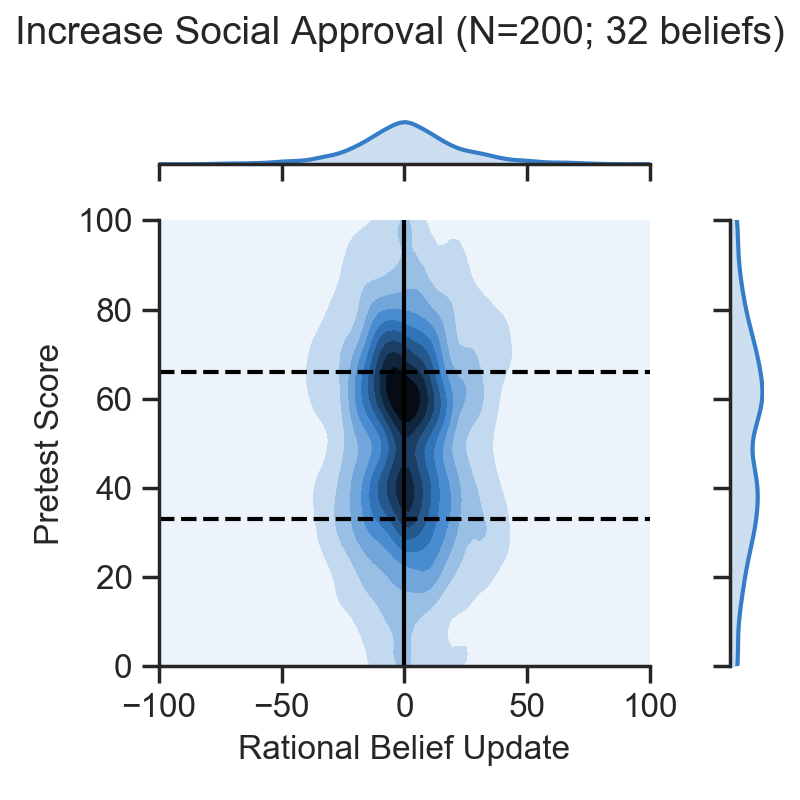

In [85]:
axs = sns.jointplot(
    data=DATA5_high,
    x="RdeltaB", y="Pre", height=4, ratio=5, color="#357EC7",
    kind="kde", xlim=[-100,100], ylim=[0,100])

axs.fig.suptitle("Increase Social Approval (N=200; 32 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')
axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")
plt.savefig('Norms.tif', dpi=300, format="tiff")

In [51]:
# Load file (from same directory as the notebook)
DATA6 = pd.read_excel(os.path.expanduser("SourceALL.xlsx"))

reorder = {k: v for k,v in enumerate([0, 1, 9, 8, 4, 5, 3, 2, 7, 6])}
DATA6.insert(2, "condfigs", DATA6["cond"].apply(lambda x: reorder[x-1]+1))
DATA6.head()

,Response ID,cond,condfigs,party,PRE_F1,PRE_F2,PRE_F3,PRE_F4,PRE_C1,PRE_C2,...,RBU8,cond.1,RB1,RB2,RB3,RB4,RB5,RB6,RB7,RB8
0,R_3OAzNXYMpzEJhdf,10,7,1,100,100,100,100,0,0,...,0,10,5,18,-20,-9,-8,0,-2,0
1,R_u24EAc1DhMLL1C1,10,7,1,84,67,42,64,0,0,...,0,10,6,-3,-2,5,-2,-1,-2,-3
2,R_1DwqheF5ajP4Mro,10,7,1,29,79,76,75,13,18,...,0,10,-21,9,14,8,-4,-4,3,0
3,R_3NEZMfYIb2unzpH,10,7,1,100,0,80,99,51,99,...,0,10,20,3,3,15,-48,-1,-98,-9
4,R_DdhkUu6fEHIZcdz,10,7,1,100,0,0,31,0,0,...,0,10,8,-9,0,10,0,0,0,0


In [52]:
# Extract columns with DATA6.target or DATA6["target"] or DATA6.loc[:,"target"]
participant = DATA6.loc[:,"Response ID"]
party = DATA6.loc[:,"party"]
condfigs = DATA6.loc[:,"condfigs"]


# Extract DATA6 with DATA6.loc[:,"DATA6start":"DATA6end"]
Pre = DATA6.loc[:, "PRE_F1":"PRE_C4"]
RBU = DATA6.loc[:, "RB1":"RB8"]

sz = Pre.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["Pre", "RBU", "itemnum", "partnum", "party", "condfigs"]
DATA6_packed = np.broadcast_arrays(Pre, RBU, itemnum, partnum)
cols = [np.tile(a, (sz[1],1)).T for a in [party, condfigs]]
DATA6_packed += cols

DATA6_unpacked = [np.reshape(a, -1) for a in DATA6_packed]

DATA6 = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, DATA6_unpacked)})

DATA6.head()

,Pre,RBU,itemnum,partnum,party,condfigs
0,100,5,0,0,1,7
1,100,18,1,0,1,7
2,100,-20,2,0,1,7
3,100,-9,3,0,1,7
4,0,-8,4,0,1,7


<IPython.core.display.Javascript object>


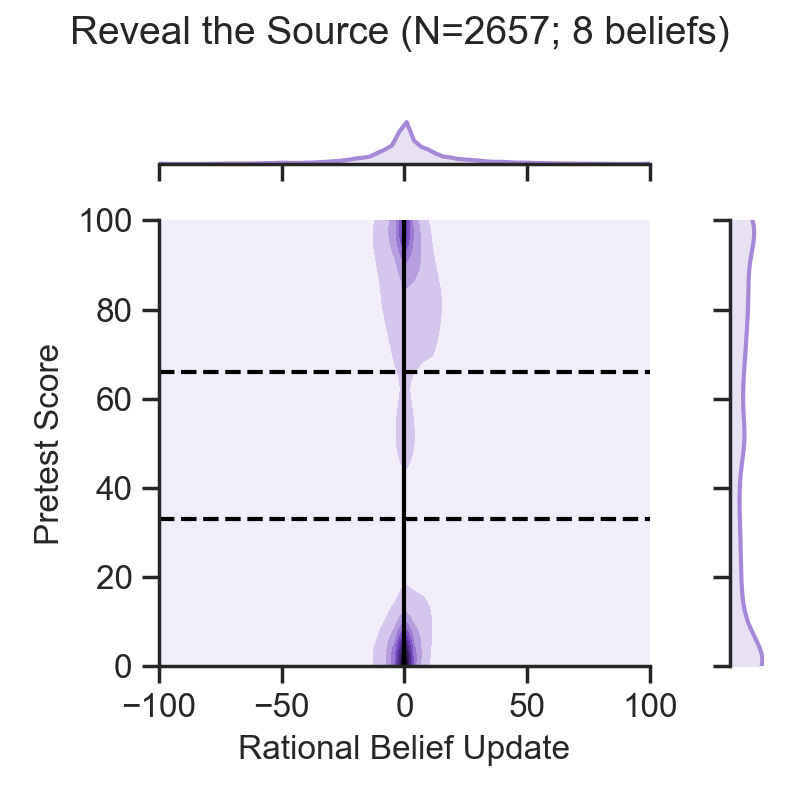

In [53]:
axs = sns.jointplot(
    data=DATA6,
    x="RBU", y="Pre", height=4, ratio=5, color="#A588D7",
    kind="kde", xlim=[-100,100], ylim=[0,100])

axs.fig.suptitle("Reveal the Source (N=2657; 8 beliefs)")
axs.fig.tight_layout()
axs.fig.subplots_adjust(top=0.85)
axs.ax_joint.set_xlabel('Rational Belief Update')
axs.ax_joint.set_ylabel('Pretest Score')

axs.ax_joint.axvline(x=0, color="black")
axs.ax_joint.axhline(y=33, linestyle='--', color="black")
axs.ax_joint.axhline(y=66, linestyle='--', color="black")

plt.savefig('Source.tif', dpi=300, format="tiff")


**Question:** Given certain beliefs at PREtest, which intervention will lead to rational belief updating (RBU > 0)?

**Implementation:** Estimate the conditional distribution of RBU given PRE, $p(\Delta B_R\mid B_\text{Pre})$, and compute the medians as a function of $B_\text{Pre}$. When that median is positive, $\Delta B_R$ is rational _for that belief at PRE_. When that median is negative, $\Delta B_R$ is irrational _for that belief at PRE_.

**Notes:**
Our Seaborn jointplots are already doing a version of this for strictly visualization purposes. To do rigorous analysis on these data, we need to expose the computational machinery, which is easy to do with ```scikit-learn```.

The [empirical] joint distribution of RBU and PRE for our data are estimated using cross-validated kernel density estimation. The kernel density estimator provides nonparametric estimates of the probability of _any_ feasible pair of RBU and PRE, including those outside the exact values in our dataset. (In a sense, we could think about this as the statistical equivalent of interpolation, minus all of the suspicious bits.) The nonparametric element is imperative for our irregularly-distributed data, as similar predictions under a parametric model (e.g. a linear model) would assume incorrectly that these data are normally-distributed.

That said, our hypothesis is about the conditional distribution of RBU _given_ PRE, since we want to understand, given some belief at PRE, whether the resulting RBU is rational. The conditional follows as the quotient of this joint distribution and the marginal distribution of PRE; this is the definition of conditional probability, 
$$p(\Delta B_R\mid B_\text{Pre}) = \frac{p(\Delta B_R, B_\text{Pre})}{ p(B_\text{Pre})}$$
where both this and the marginal $p(B_\text{Pre})=\int p(\Delta B_R, B_\text{Pre})\,d\Delta B_R$ can be computed using numerical integration methods on the KDE.

From the conditional distribution, we can ask what proportion of belief updates were rational (RBU > 0) as a function of PRE. The higher proportion of positive updates, the more effective the intervention was; this continued nonparametric perspective from the KDE should be more outlier-sensitive than a mean- or model-based approach. These proportions are equivalently 1 minus the cumulative conditional probability, where the CDF provides the probability that the RBU was _at most_ some value (in our case, 0):
$$\rho = \Pr[\Delta B_R \ge 0\mid B_\text{Pre}] = 1 - \int_{\Delta B_R \le t} p(\Delta B_R\mid B_\text{Pre})\,d\Delta B_R$$
where again, this can be computed using numerical integration methods.

In [54]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import itertools
from scipy.integrate import cumtrapz

def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

<IPython.core.display.Javascript object>


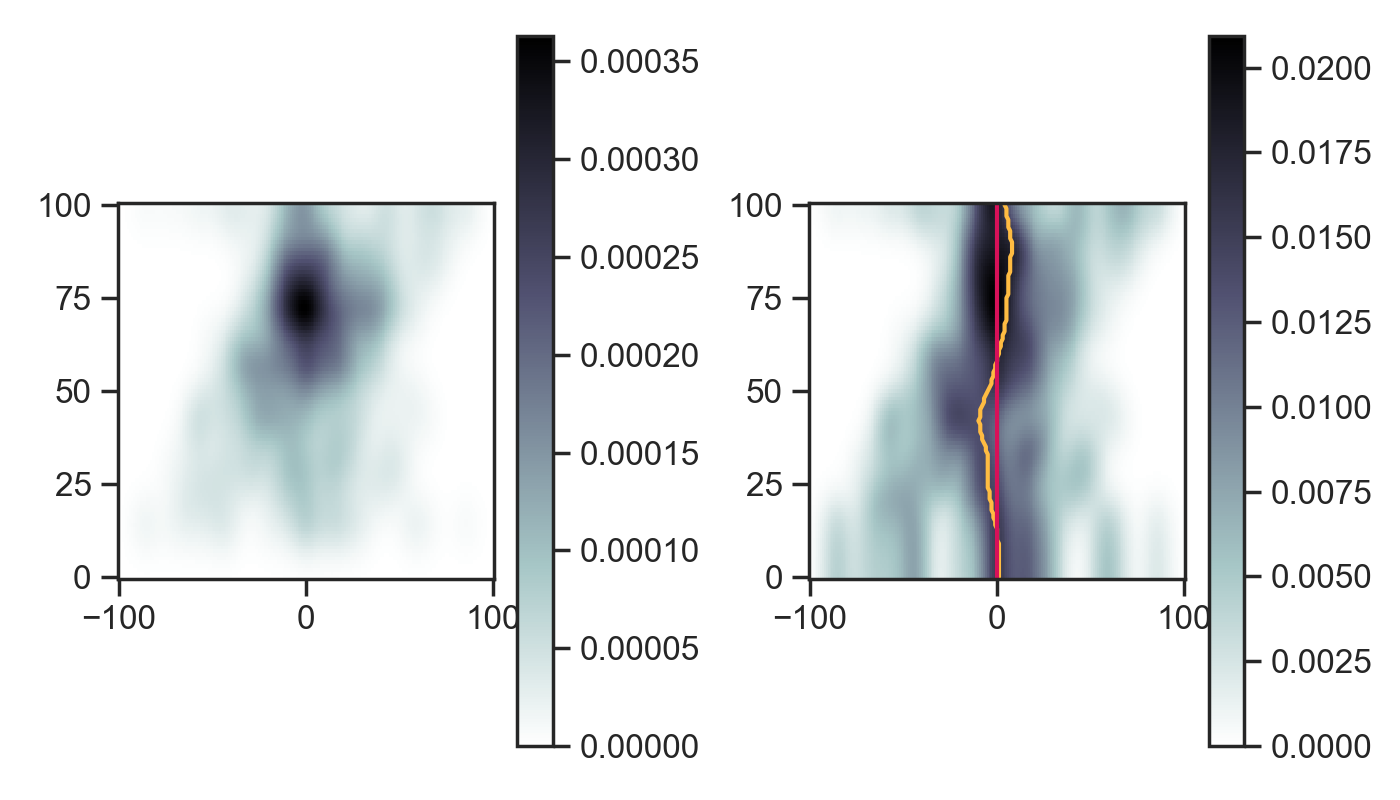

In [68]:
data = np.array(DATA1.loc[:, ["Pre", "RBU"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=gs.best_estimator_.bandwidth, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


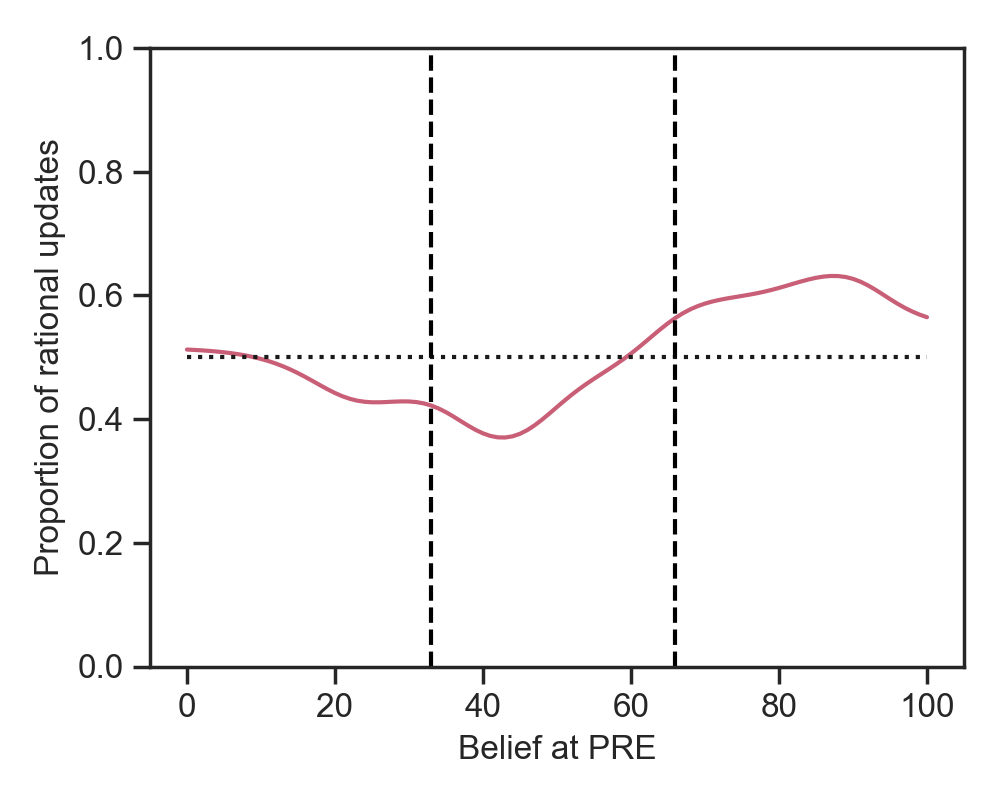

In [73]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#C95E77")
plt.plot([0, 100], [0.5, 0.5], c='k', ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)
plt.tight_layout()

<IPython.core.display.Javascript object>


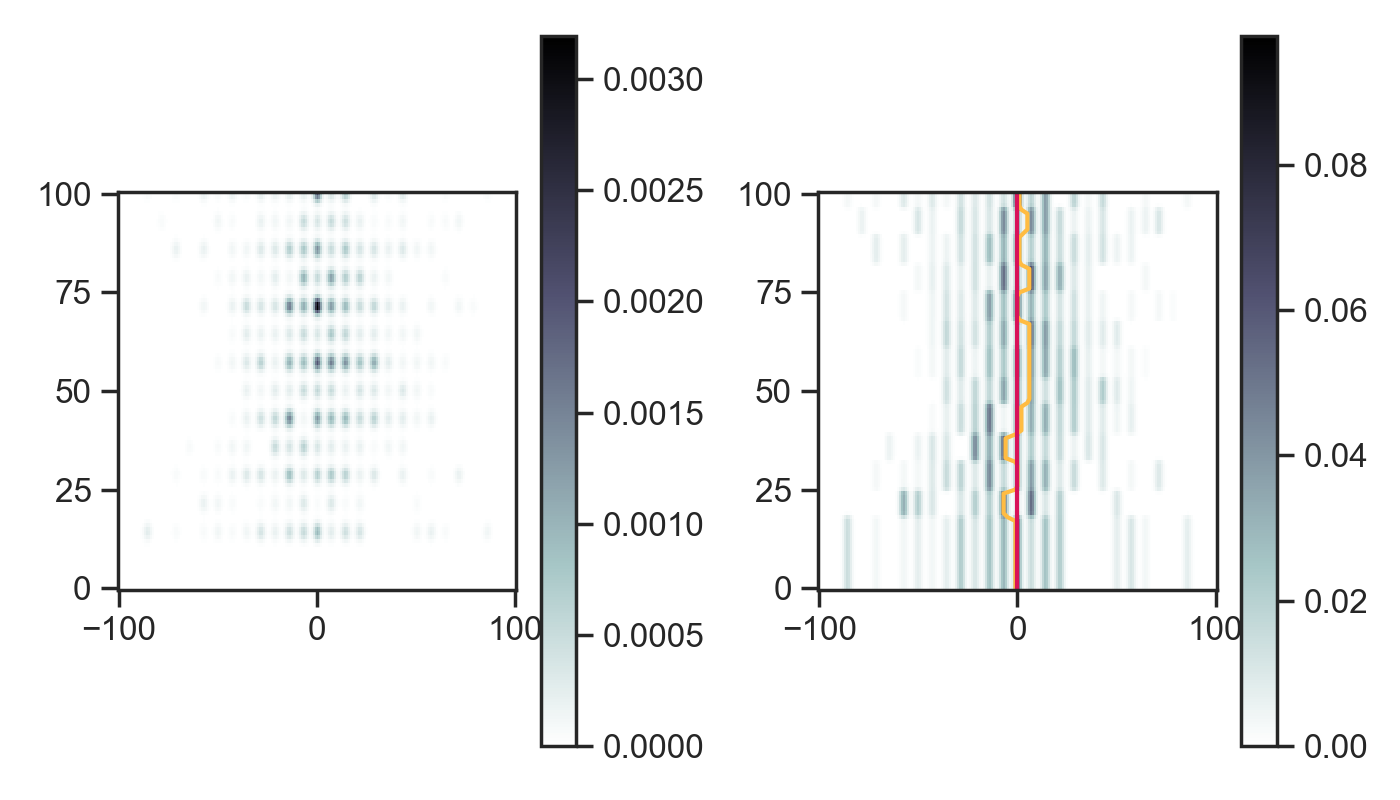

In [74]:
data = np.array(DATA2.loc[:, ["Pre", "RBU"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=gs.best_estimator_.bandwidth, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


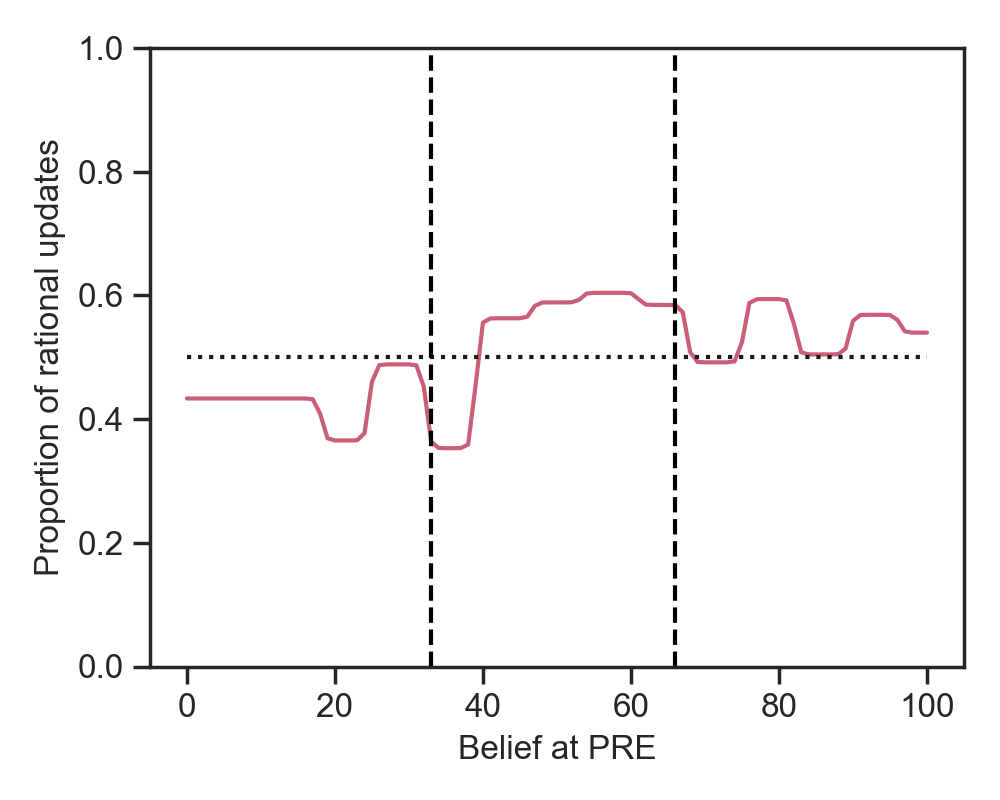

In [75]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#C95E77")
plt.plot([0, 100], [0.5, 0.5], c="k", ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)

plt.tight_layout()

<IPython.core.display.Javascript object>


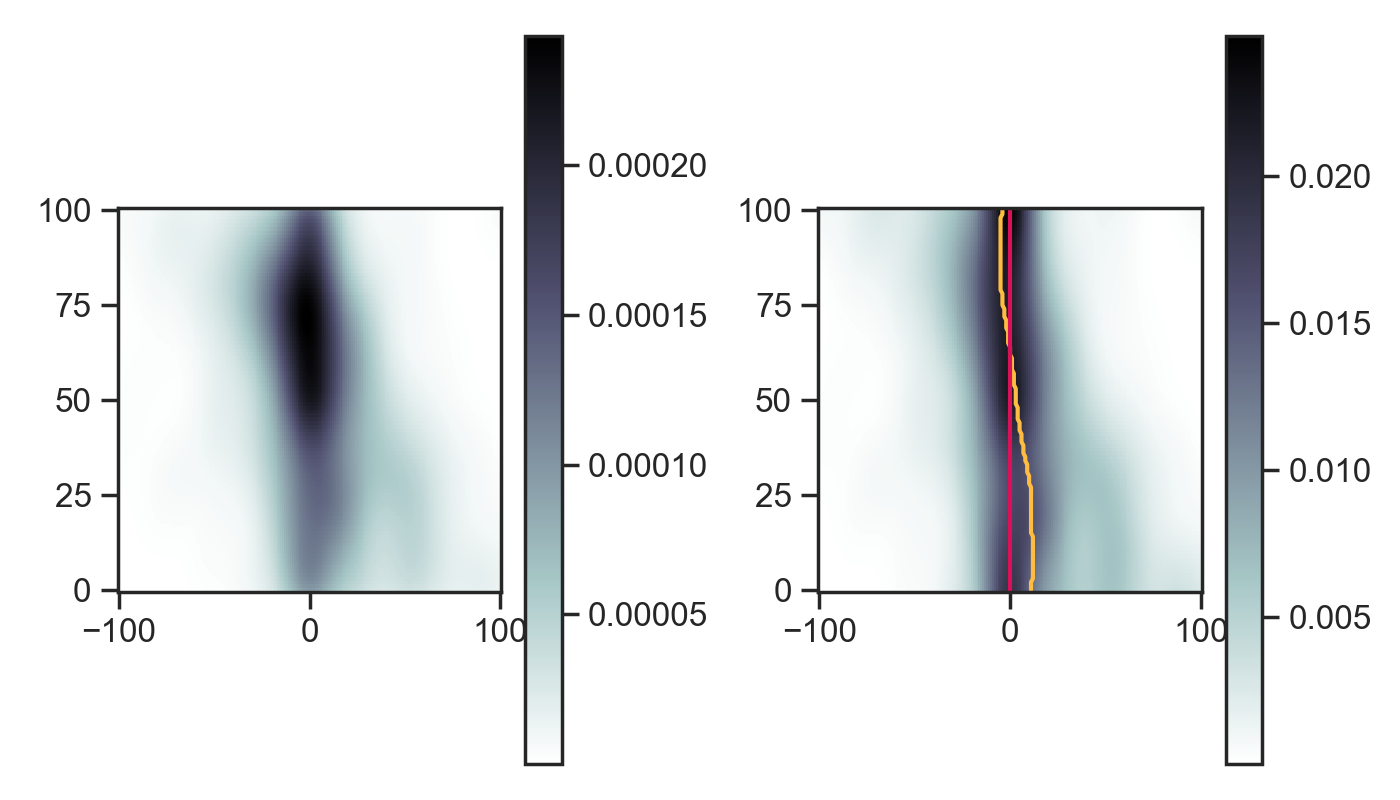

In [76]:
data = np.array(DATA3.loc[:, ["Pre", "RBU"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=gs.best_estimator_.bandwidth, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


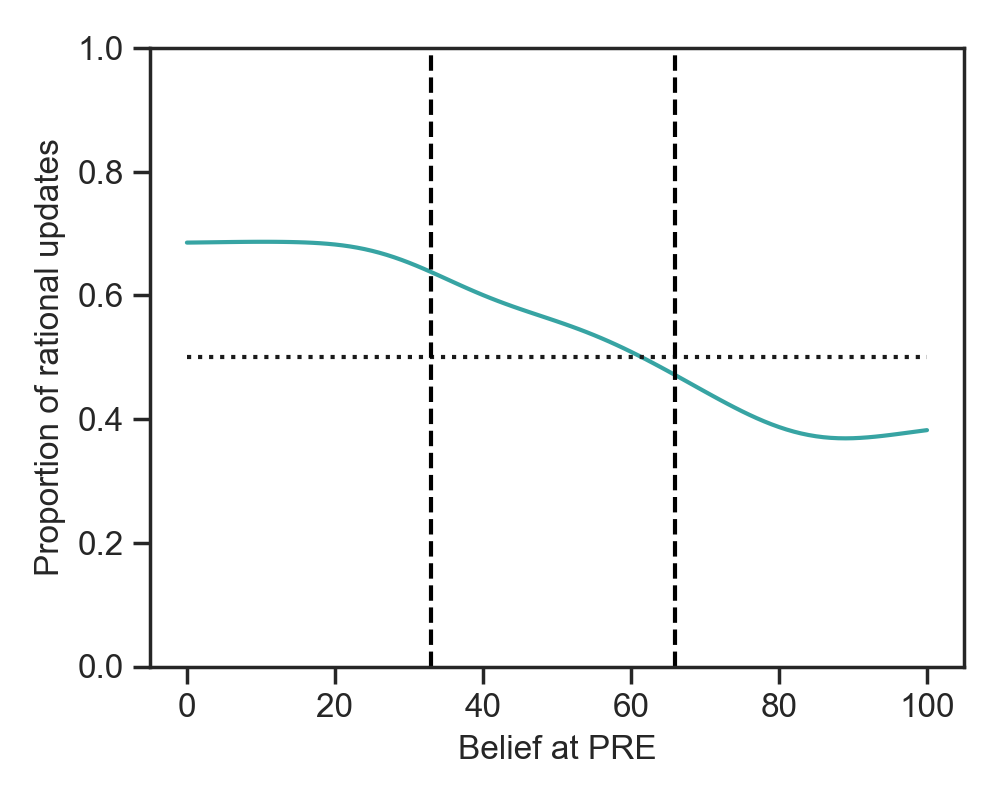

In [77]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#37A4A3")
plt.plot([0, 100], [0.5, 0.5], c="k", ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)

plt.tight_layout()

<IPython.core.display.Javascript object>


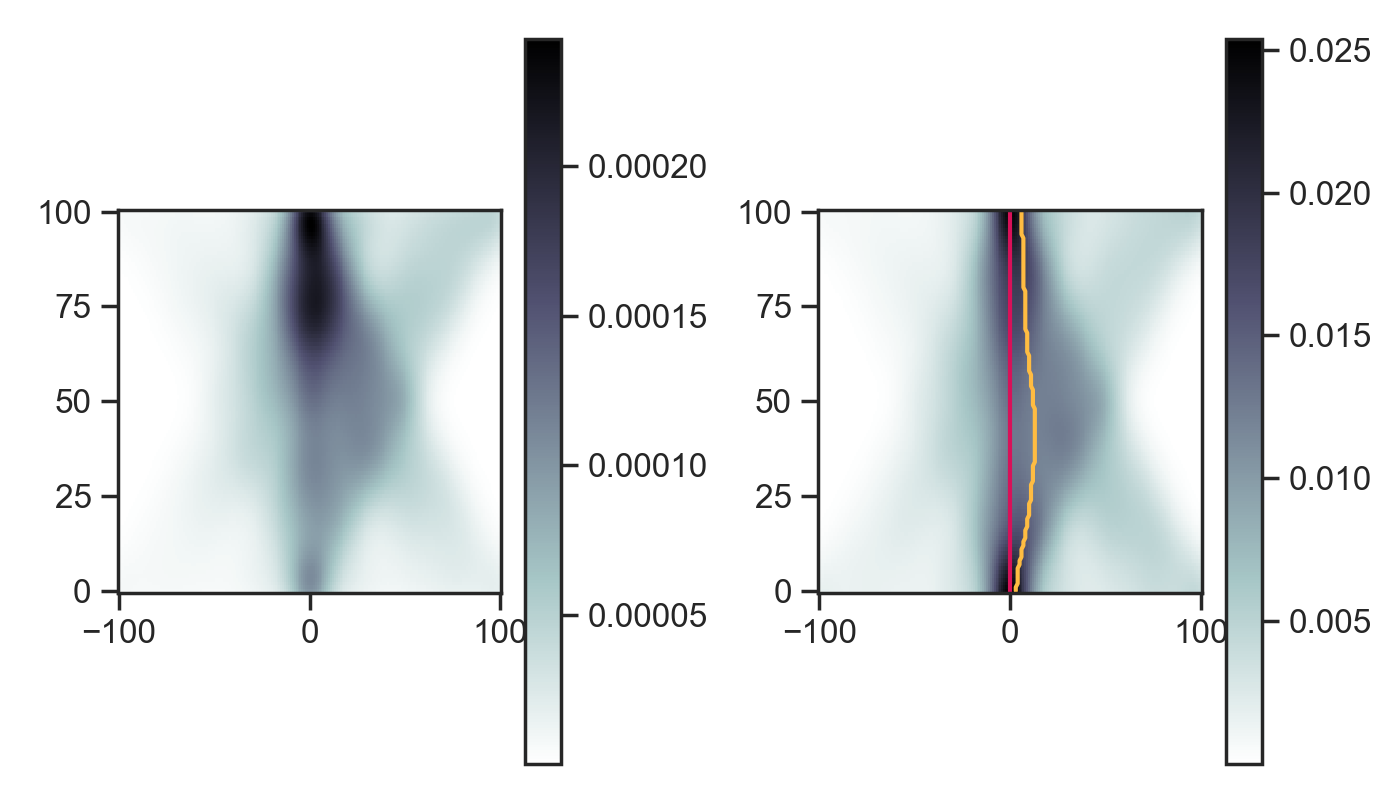

In [78]:
data = np.array(DATA4.loc[:, ["Bpre", "RdeltaB"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
# gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=7, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


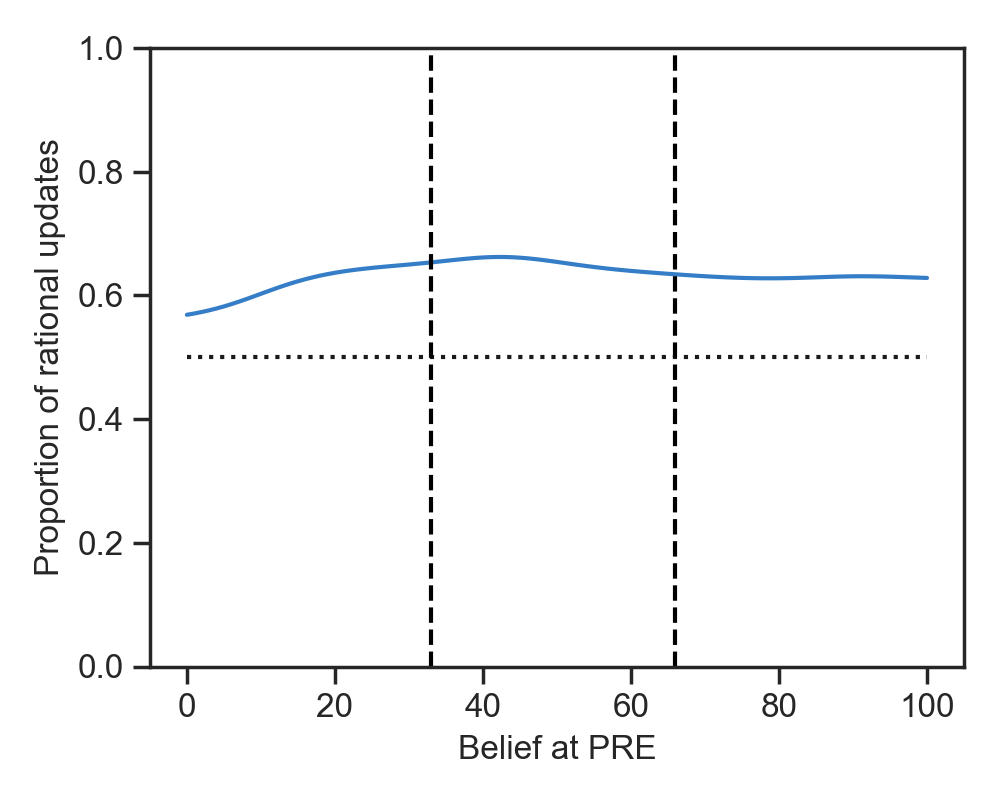

In [80]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#357EC7")
plt.plot([0, 100], [0.5, 0.5], c="k", ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)

plt.tight_layout()

<IPython.core.display.Javascript object>


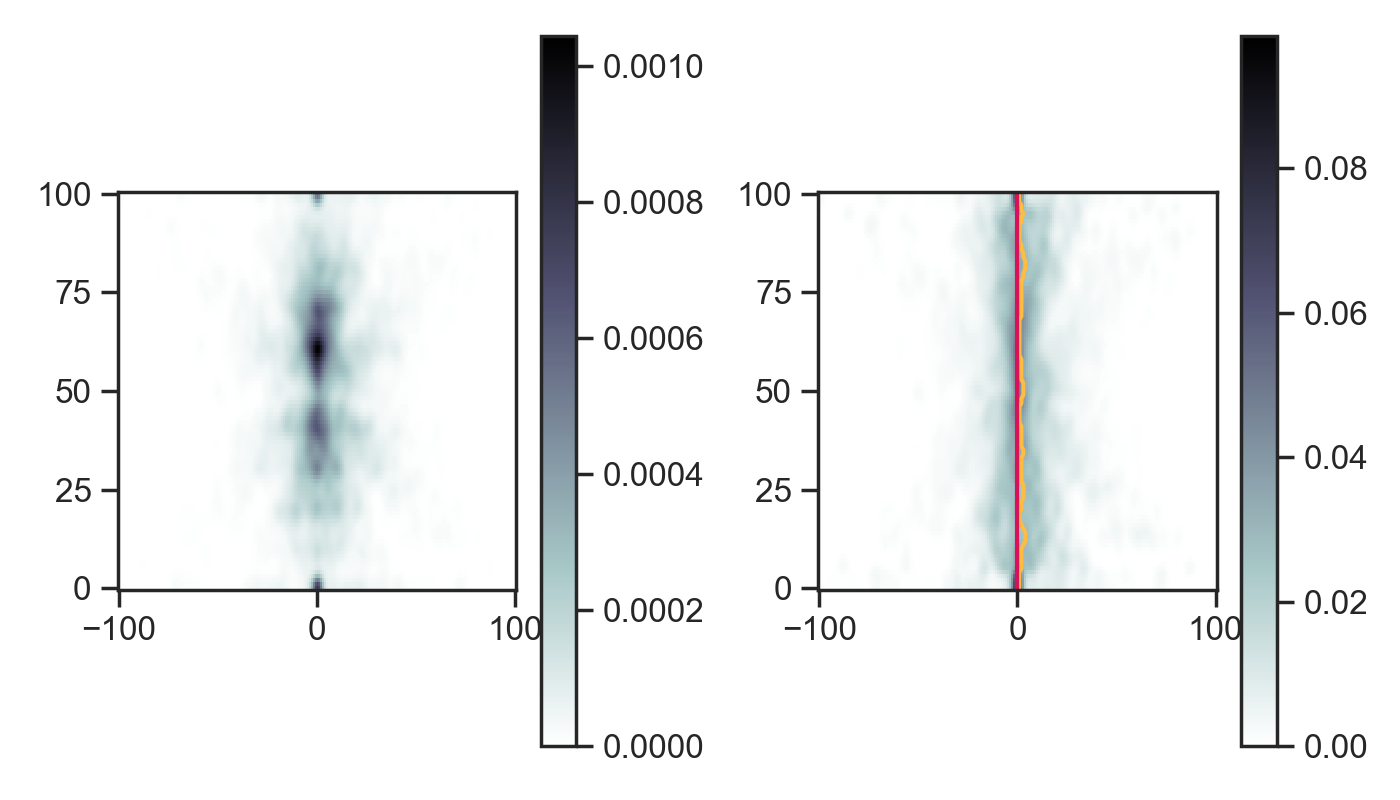

In [81]:
data = np.array(DATA5.loc[:, ["Pre", "RdeltaB"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=gs.best_estimator_.bandwidth, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


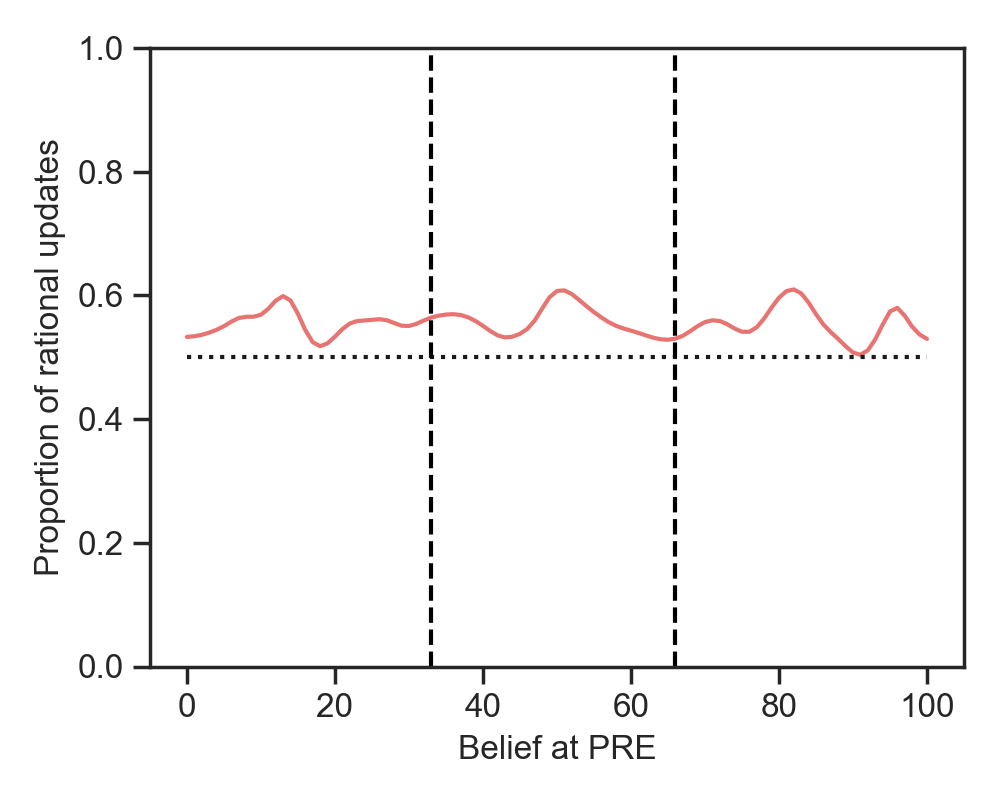

In [82]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#E77471")
plt.plot([0, 100], [0.5, 0.5], c="k", ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)

plt.tight_layout()

<IPython.core.display.Javascript object>


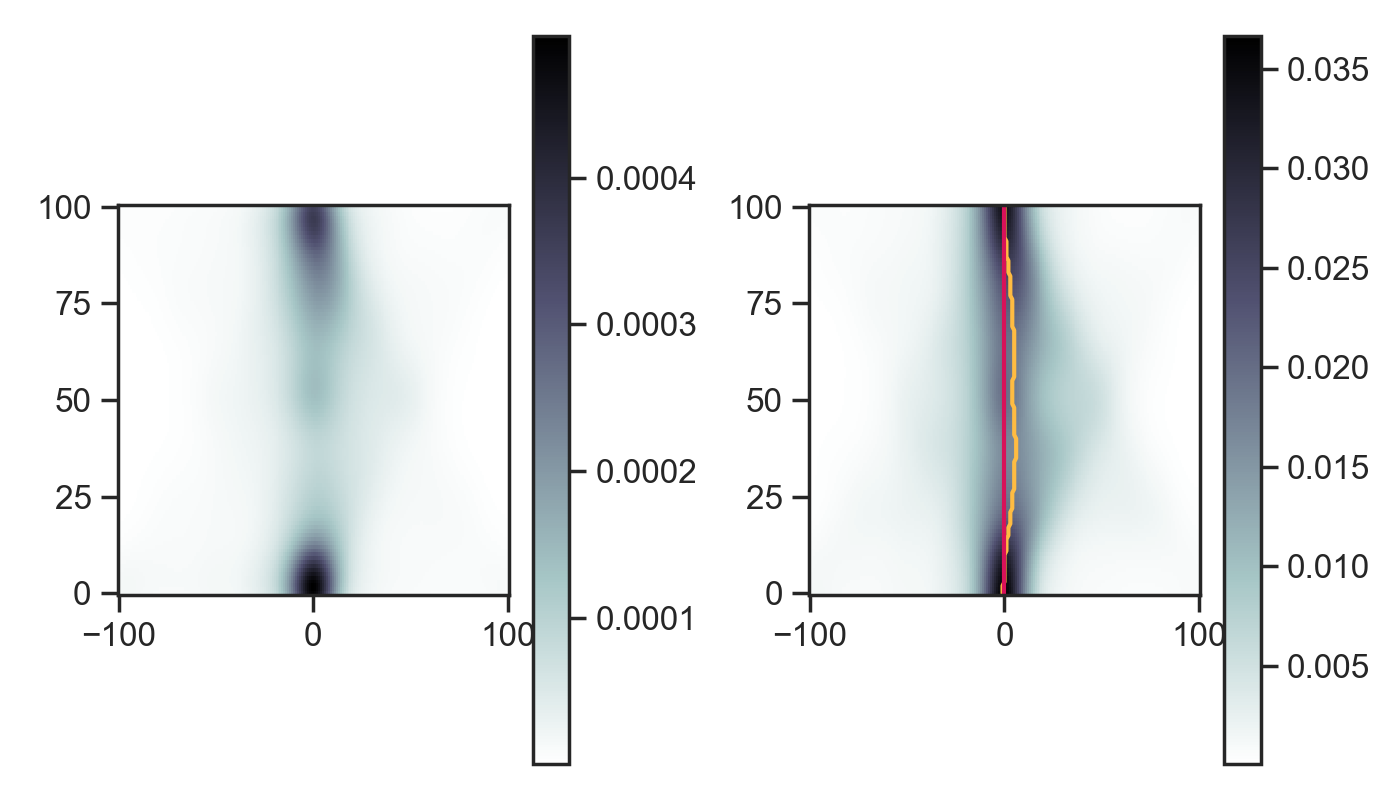

In [83]:
data = np.array(DATA6.loc[:, ["Pre", "RBU"]])
Pre_grid = np.linspace(0, 100, 101)
RBU_grid = np.linspace(-100, 100, 201)

# Gridsearch cross-validation to find best KDE bandwidth
params = {"bandwidth": np.logspace(0, np.log(20), 20)}
gs = GridSearchCV(KernelDensity(), params)
# gs.fit(data)
# Plug this bandwidth into the KDE and fit to data
kde = KernelDensity(bandwidth=7, kernel="gaussian")
kde.fit(data)
# Predict on a grid for [empirical] joint distribution
xy = np.array(list(itertools.product(Pre_grid, RBU_grid)))
jointprob = np.exp(kde.score_samples(xy)).reshape(Pre_grid.size, -1)
# Compute marginal probability of "Pre", and divide to get the conditional probability
marginalprob = np.trapz(jointprob, dx=1, axis=-1)
condprob = jointprob / marginalprob[:, np.newaxis]
# Compute empirical median
condcdf = cumtrapz(condprob, dx=1, axis=-1, initial=0.)
empiricalmedian = lambda row: RBU_grid[np.where(row > 0.5)[0][0]]
medianRBU = np.vectorize(empiricalmedian, signature='(m)->()')(condcdf)
proportionRBU = 1.0 - condcdf[:, RBU_grid.size // 2] # survival function

# Plot
fig, ax = plt.subplots(1,2, figsize=(7,4))
h = ax[0].imshow(jointprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower", 
                 extent=extents(RBU_grid) + extents(Pre_grid))
plt.colorbar(h, ax=ax[0])
h = ax[1].imshow(condprob, cmap=plt.get_cmap("bone_r"), aspect=201/101, origin="lower",
                 extent=extents(RBU_grid) + extents(Pre_grid))
ax[1].plot(medianRBU, Pre_grid, color="#FFBC42")
ax[1].axvline(0, color="#D81159")
plt.colorbar(h, ax=ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


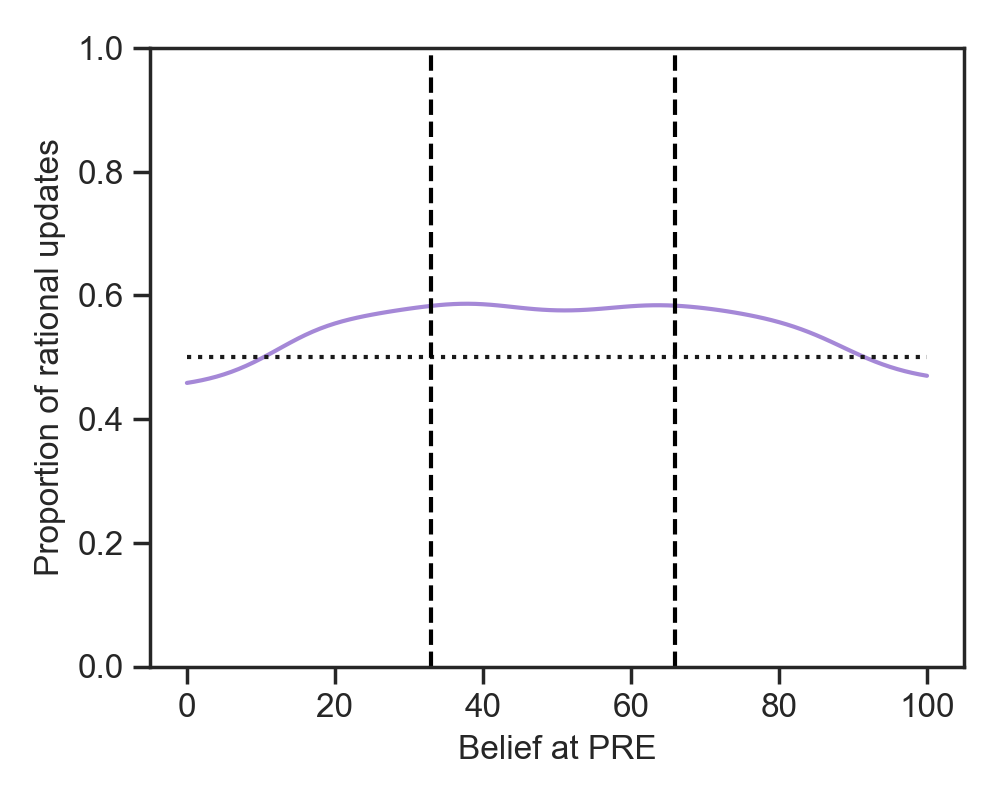

In [84]:
plt.figure(figsize=(5,4))
plt.plot(Pre_grid, proportionRBU, color="#A588D7")
plt.plot([0, 100], [0.5, 0.5], c="k", ls=":")
plt.xlabel("Belief at PRE")
plt.ylabel("Proportion of rational updates")
plt.gca().axvline(33, linestyle='--', color="black")
plt.gca().axvline(66, linestyle='--', color="black")
plt.ylim(0,1)

plt.tight_layout()